# Load Packages

In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt
import quantecon as quantecon
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
import statsmodels.api as sm
import matplotlib.ticker as ticker
from statsmodels.tsa.filters.hp_filter import hpfilter
from quantecon import hamilton_filter

#### Chosen country:  
USA

#### Period covers:  
2001.Q1 – 2020.Q4

#### Links to the pages from which data was downloaded:
* GDP: https://fred.stlouisfed.org/series/GDP
* CPI: https://fred.stlouisfed.org/series/USACPICORMINMEI
* S&P: from yfinance library (Code below)
* the 3-month interest rate: https://fred.stlouisfed.org/series/FEDFUNDS

### a)	Downloading quarterly data on real GDP, the (core) consumer price index, the 3-month interest rate, and the main national stock market index

In [3]:
# Load macroeconomic data quarterly from csv file and create DataFrame with all indexes
df = pd.read_csv("CPI.csv")
gdp = pd.read_csv("GDP.csv")
""" # For downloading data to csv
start_date = '2001-01-01'
end_date = '2021-01-01'
data = yf.download(tickerSymbol, start=start_date, end=end_date, interval='3mo')
data.to_csv("C:/Users/Asus/Desktop/Homework3/SP.csv") # saved to csv
"""
sp = pd.read_csv("SP.csv")
rate = pd.read_csv("FEDFUNDS.csv")
rate = rate.rename({"FEDFUNDS": "Rate"}, axis = 'columns')
df = df.rename({"USACPICORMINMEI": "CPI"}, axis ='columns')
df['GDP'] = gdp['GDP']
df['S&P'] = sp['Close']
df['InterestRate'] = rate['Rate']
df['DATE'] = pd.to_datetime(df['DATE'])
df = df.set_index('DATE')
df_original = df.copy()
df.head(5)

,CPI,GDP,S&P,InterestRate
DATE,,,,
2001-01-01,76.120811,10470.231,1160.329956,5.593333
2001-04-01,76.643694,10599.000,1224.380005,4.326667
2001-07-01,77.042737,10598.020,1040.939941,3.496667
2001-10-01,77.538100,10660.465,1148.079956,2.133333
2002-01-01,78.047223,10783.500,1147.390015,1.733333


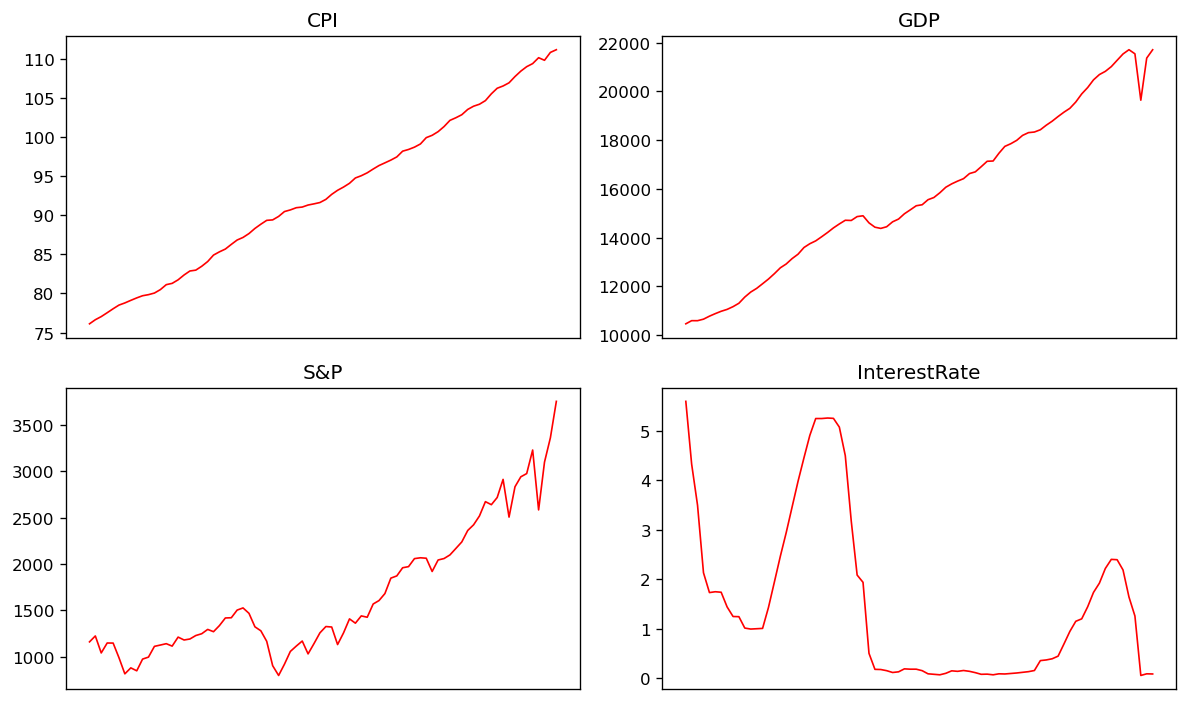

In [3]:
# Plot non-transformed data
fig, axes = plt.subplots(nrows=2, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    ax.set_title(df.columns[i])
    xtick_locs = [tick for tick in data if tick % 5 == 1]
    xtick_labels = [f"Label {tick}" for tick in xtick_locs]
    ax.set_xticks(xtick_locs)
    ax.set_xticklabels(xtick_labels)
plt.tight_layout();

### b)	Transform the index data to log, and make the series stationary. Describe how you did it and why we do this. How do you handle potential seasonality? 

In [4]:
# Transforming the index data to log
df['CPI'] = df['CPI'].apply(lambda x: np.log(x))
df['GDP'] = df['GDP'].apply(lambda x: np.log(x))
df['S&P'] = df['S&P'].apply(lambda x: np.log(x))
df['InterestRate'] = df['InterestRate'].apply(lambda x: np.log(x))
df3 = df.copy()

In [5]:
# Check for statonarity 
for col in df.columns:
    result = adfuller(df[col])
    print(f"ADF Statistic for {col}: {result[0]}")
    print(f"p-value for {col}: {result[1]}")
    print(f"Critical values for {col}: {result[4]}")
    print('\n')

ADF Statistic for CPI: -0.020606419900624284
p-value for CPI: 0.956794409414283
Critical values for CPI: {'1%': -3.520713130074074, '5%': -2.9009249540740742, '10%': -2.5877813777777776}


ADF Statistic for GDP: -1.0655161505018993
p-value for GDP: 0.7286259982835044
Critical values for GDP: {'1%': -3.517113604831504, '5%': -2.8993754262546574, '10%': -2.5869547797501644}


ADF Statistic for S&P: 0.24029501742197612
p-value for S&P: 0.9744331921040303
Critical values for S&P: {'1%': -3.5159766913976376, '5%': -2.898885703483903, '10%': -2.5866935058484217}


ADF Statistic for InterestRate: -1.8585295380438318
p-value for InterestRate: 0.3518143894916678
Critical values for InterestRate: {'1%': -3.518281134660583, '5%': -2.899878185191432, '10%': -2.5872229937594873}




The null hypothesis is that the time series has a unit root, which indicates that the series is non-stationary
Since p-value of the ADF test in each case is greater than 0.05, then we fail to reject the null hypothesis and conclude that the series is non-stationary.

#### Removing stationarity 
We will try to remove stationarity by differencing. Differencing requires subtracting recent value from previous one in a time series. In doing so, we can eliminate the general trend or seasonality in the initial series and produce a new, stationary series.

In [6]:
diff1 = df.diff(periods=1)
diff1 = diff1.iloc[1:,:]
for col in diff1.columns:
    result = adfuller(diff1[col])
    print(f"ADF Statistic for {col}: {result[0]}")
    print(f"p-value for {col}: {result[1]}")
    print(f"Critical values for {col}: {result[4]}")
    print('\n')

ADF Statistic for CPI: -3.1142134338812526
p-value for CPI: 0.025519055994216933
Critical values for CPI: {'1%': -3.520713130074074, '5%': -2.9009249540740742, '10%': -2.5877813777777776}


ADF Statistic for GDP: -10.570379082195211
p-value for GDP: 7.33143890732848e-19
Critical values for GDP: {'1%': -3.517113604831504, '5%': -2.8993754262546574, '10%': -2.5869547797501644}


ADF Statistic for S&P: -4.139378422550694
p-value for S&P: 0.000833124091885612
Critical values for S&P: {'1%': -3.5232835753964475, '5%': -2.902030597326081, '10%': -2.5883710883843123}


ADF Statistic for InterestRate: -7.447428914955782
p-value for InterestRate: 5.788594991999579e-11
Critical values for InterestRate: {'1%': -3.517113604831504, '5%': -2.8993754262546574, '10%': -2.5869547797501644}




From the results above, we can see that p-value is less than 0.05 which means that each index time series have become stationary after differencing.

### How do you handle potential seasonality? 

1) In our case, we used seasonal differencing. It is the fastest and easiest way that can make time series stationary. A seasonal difference involves taking the difference between the observation's value and the prior observation's value. First, a time series variance can be stabilized using transformations like logarithms. Second, by reducing changes in a time series by differencing, we can try to stabilize the mean of the time series. Thus, the seasonality and trend would be minimized.

2) Seasonal decomposition also can be used where the time series is divided into trend and seasonal components.


### c)	Include the stationary data in a VAR model and estimate it using Maximum Likelihood. Use the BIC to choose the lag length, and report how many lags you use. 

In [7]:
# Run VAR model for our indexes and make order selection. By using the BIC we will choose the lag length
var = VAR(diff1)
x = var.select_order()
x.summary()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


,AIC,BIC,FPE,HQIC
0,-28.03,-27.90*,6.723e-13,-27.98
1,-28.47,-27.82,4.319e-13*,-28.21*
2,-28.43,-27.26,4.510e-13,-27.97
3,-28.38,-26.68,4.814e-13,-27.71
4,-28.46,-26.24,4.558e-13,-27.58
5,-28.47,-25.73,4.705e-13,-27.38
6,-28.58*,-25.32,4.454e-13,-27.29
7,-28.48,-24.70,5.386e-13,-26.98
8,-28.43,-24.12,6.449e-13,-26.72
9,-28.32,-23.49,8.464e-13,-26.41


In the output above, the BIC drops to lowest at lag 0, then increases continuously after lag 1.
Thus, we choose lag 1 for our analysis.

In [8]:
# Train the model of selected order and print the results
results = var.fit(1, method='mle')
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 13, Apr, 2023
Time:                     22:37:53
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -27.9435
Nobs:                     78.0000    HQIC:                  -28.3059
Log likelihood:           690.656    FPE:                4.00083e-13
AIC:                     -28.5478    Det(Omega_mle):     3.12044e-13
--------------------------------------------------------------------
Results for equation CPI
                     coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------
const                   0.004399         0.000685            6.427           0.000
L1.CPI                  0.102163         0.128988            0.792           0.428
L1.GDP                 -0.022170         0.025329     

From that table above, we can see all coefficients, standard error value, t-test and the model’s probabilities at every lag till 1 lag. 

### d)	Plot the actual data and the fitted values and comment on the results.

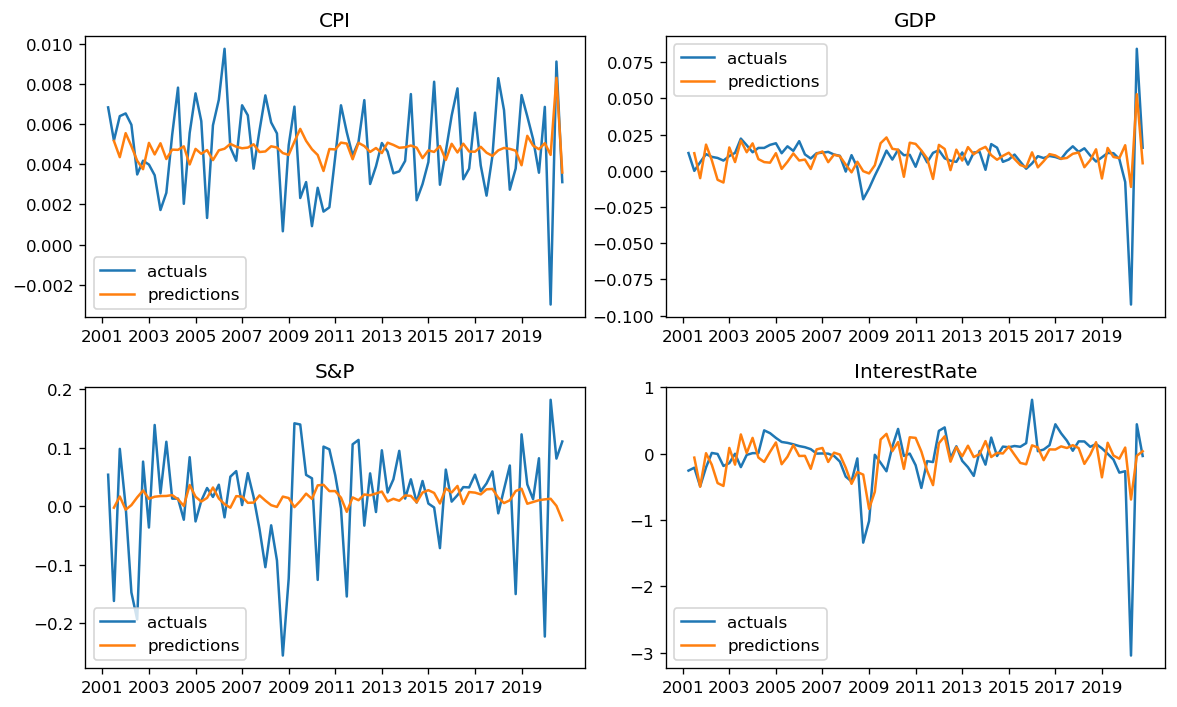

In [9]:
pred = results.fittedvalues
fig, axes = plt.subplots(nrows=2, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    ax.plot(diff1.iloc[:,i], label='actuals')
    ax.plot(pred.iloc[:,i], label='predictions')
    ax.set_title(diff1.columns[i])
    years = pd.date_range(start=df.index[0], end=df.index[-1], freq='2AS')
    ax.set_xticks(years)
    year_labels = [year.strftime('%Y') for year in years]
    ax.set_xticklabels(year_labels)
    ax.legend()
plt.tight_layout();

#### Comment:
From the graphs above, we can conclude that four VAR curves have a certain deviation from the actual value. Prediction results have a pattern that is similar to actual values but they have smaller deviations from the mean.


Predicted lines closely replicate the actual lines in the graph, and the VAR accurately forecast the actual values of interest rate and GDP. However, there are some periods where the actual values deviate significantly from the predicted values. In 2008-2009, and 2020 during the recession, the predicted values underestimated the severity of the downturn.

### e)	Truncate the estimation sample to end in 2019.Q4, and re-estimate the model

In [10]:
# Split data by train (from 2001.Q2 to 2019.Q4) and test (2020.Q1-2020.Q4)
nobs = 4
df_train, df_test = diff1[0:-nobs], diff1[-nobs:]
print(df_train.shape)
print(df_test.shape)

(75, 4)
(4, 4)


In [11]:
# Order selection
var = VAR(df_train)
x = var.select_order()
x.summary()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


,AIC,BIC,FPE,HQIC
0,-30.63,-30.49*,5.001e-14,-30.57*
1,-30.80,-30.12,4.214e-14,-30.53
2,-30.68,-29.47,4.779e-14,-30.20
3,-30.69,-28.94,4.784e-14,-30.00
4,-30.81,-28.52,4.380e-14,-29.91
5,-30.62,-27.78,5.595e-14,-29.50
6,-31.00,-27.62,4.114e-14*,-29.67
7,-30.88,-26.97,5.152e-14,-29.34
8,-30.84,-26.38,6.291e-14,-29.08
9,-31.16,-26.17,5.611e-14,-29.20


We will choose the lag 1 order by BIC criteria

In [12]:
# Train the VAR Model of Selected Order(1)
model_fitted = var.fit(1, method='mle')
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 13, Apr, 2023
Time:                     22:37:55
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -30.1321
Nobs:                     74.0000    HQIC:                  -30.5065
Log likelihood:           737.924    FPE:                4.40241e-14
AIC:                     -30.7549    Det(Omega_mle):     3.38929e-14
--------------------------------------------------------------------
Results for equation CPI
                     coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------
const                   0.004106         0.000744            5.523           0.000
L1.CPI                  0.172844         0.119803            1.443           0.149
L1.GDP                 -0.013038         0.044908     

In [13]:
# make predictions
pred = model_fitted.forecast(df_train.values[-1:], len(df_test))

In [14]:
# create DataFrame from predicted values
pred_df = pd.DataFrame(pred, index=df_test.index, columns=df_test.columns)
pred_df

,CPI,GDP,S&P,InterestRate
DATE,,,,
2020-01-01,0.004577,0.009138,0.008983,-0.071385
2020-04-01,0.004776,0.009214,0.011918,-0.039484
2020-07-01,0.004805,0.009392,0.012570,-0.026710
2020-10-01,0.004807,0.009512,0.012976,-0.020532


In [15]:
# Concatenate train data with forecast which woould be used in plotting
df2 = df_train.copy()
df2 = pd.concat([df2, pred_df], axis = 0)
df2.tail(10)

,CPI,GDP,S&P,InterestRate
DATE,,,,
2018-07-01,0.002738,0.010549,0.069487,0.102092
2018-10-01,0.003794,0.006360,-0.150493,0.143447
2019-01-01,0.007461,0.009266,0.122803,0.079349
2019-04-01,0.006399,0.012267,0.037178,-0.002778
2019-07-01,0.005262,0.012120,0.011821,-0.090177
2019-10-01,0.003585,0.008081,0.081895,-0.287175
2020-01-01,0.004577,0.009138,0.008983,-0.071385
2020-04-01,0.004776,0.009214,0.011918,-0.039484
2020-07-01,0.004805,0.009392,0.012570,-0.026710


##### Comment:
This type of analysis is a reasonable because it enables to assess how well the model performs in predicting actual values during a time for which we do not observe data. This method can give insightful information about the model's accuracy and robustness.

### f)	Plot the actual data and the predicted values for the period 2020.Q1 – 2020.Q4. 

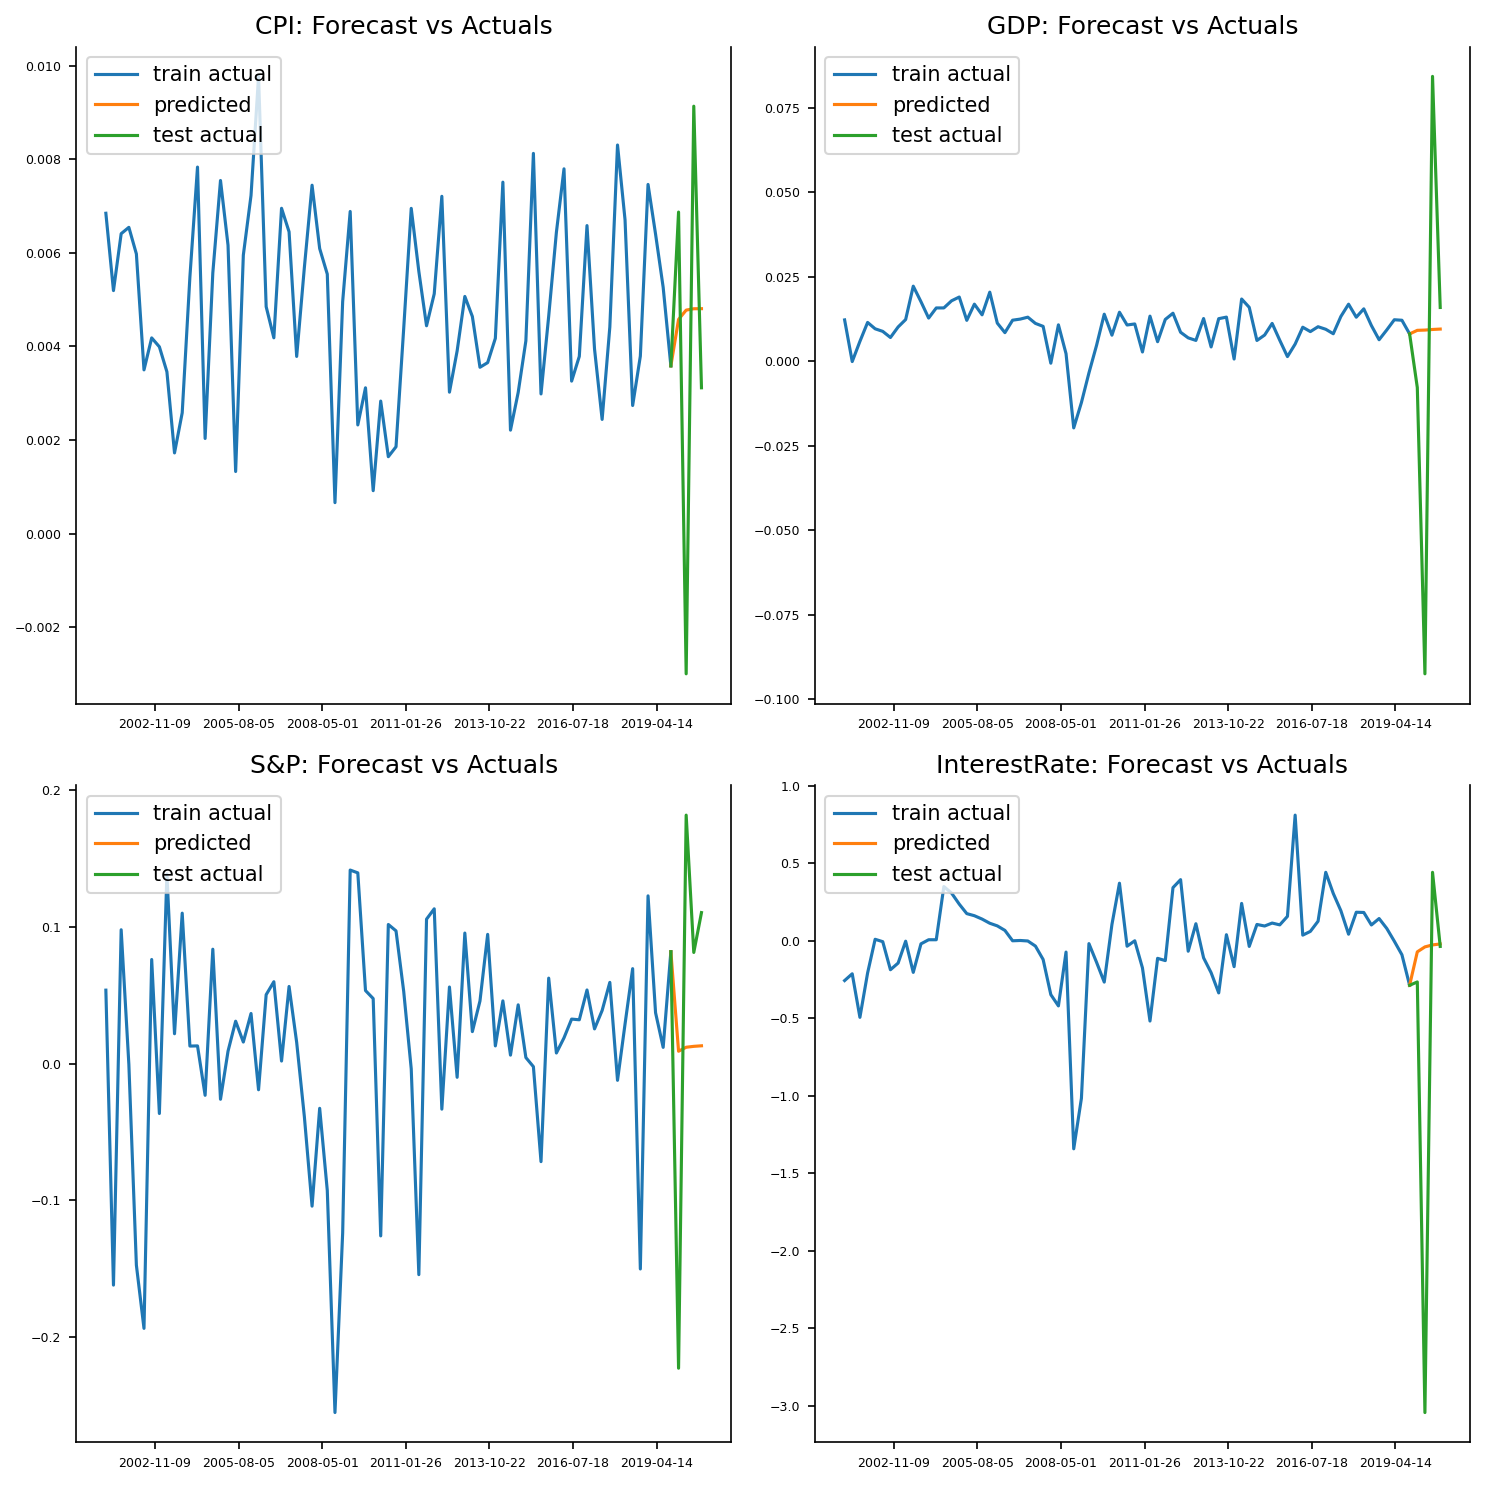

In [16]:
# Plotting the train data from 2001.Q1 to 2019.Q4 with predicted for 2020.Q1 – 2020.Q4 and real data(test) from 2020.Q1 - 2020.Q4
fig, axes = plt.subplots(nrows=int(len(df.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    ax.plot(df_train.iloc[:,i], label='train actual')  # train data
    ax.plot(df2.iloc[-5:,i], label='predicted')        # predicted value
    ax.plot(diff1.iloc[-5:,i], label='test actual')   
    ax.set_title(col + ": Forecast vs Actuals")
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)
    ax.legend(loc='upper left')
    ax.xaxis.set_major_locator(ticker.MaxNLocator(9))
plt.tight_layout();

##### Comment:

Predicted lines for 2020 doesn't replicate the actual line in the graph which means that VAR forecast is not accurate. The actual value deviate significantly from the predicted values probably because 2020 was the year of the recession (COVID-19) and the predicted values underestimated the severity of the downturn

### g)	Convert the predicted values to levels

In [17]:
# calculate cumulative sum of differences
cumsum = np.cumsum(pred_df, axis=0)
pred_levels = cumsum + df3.iloc[-5]
pred_exp = np.exp(pred_levels)
pred_exp

,CPI,GDP,S&P,InterestRate
DATE,,,,
2020-01-01,109.908641,21905.792439,3259.932232,1.530112
2020-04-01,110.434830,22108.558910,3299.015592,1.470875
2020-07-01,110.966782,22317.173147,3340.746031,1.432109
2020-10-01,111.501457,22530.473455,3384.377879,1.403005


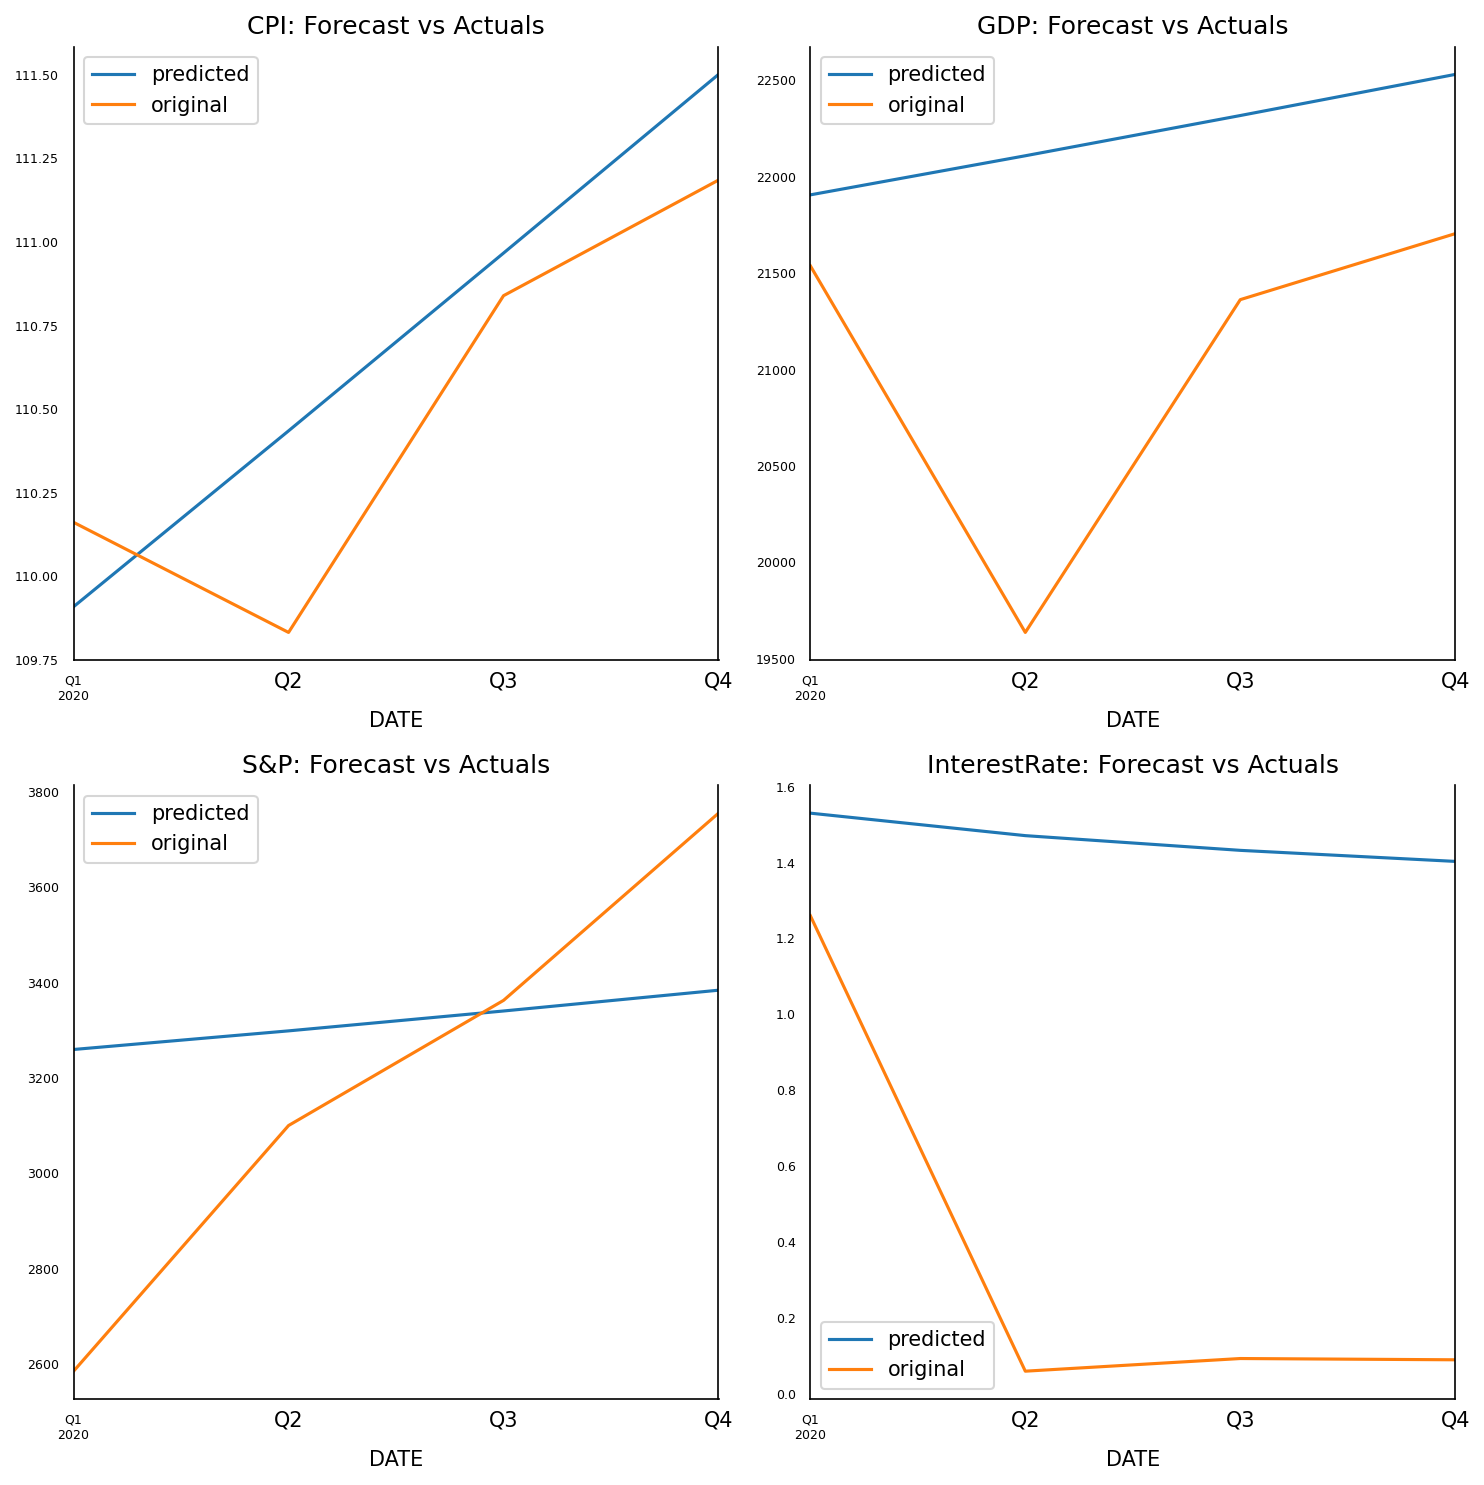

In [18]:
# PLotting the results
fig, axes = plt.subplots(nrows=int(len(df.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    pred_exp[col].plot(label='predicted',legend=True, ax=ax)
    df_original[col][-4:].plot(label='original',legend=True, ax=ax).autoscale(axis='x',tight=True)
    #df_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [19]:
# 1) How many percent did the GDP level fall during the two first quarters of 2020, and how much did the GDP level fall relative to the predicted values
perc_change_orig = (df_original['GDP'][-3] - df_original['GDP'][-4])/ df_original['GDP'][-4] * 100
perc_change_predicted = (pred_exp['GDP'][1] - pred_exp['GDP'][0]) / pred_exp['GDP'][0] * 100
print(f"By {round(perc_change_orig,2)} % GDP level fall during the two first quarters of 2020")
print(f"By VAR prediction GDP level increase by {round(perc_change_predicted,2)} % during the two first quarters of 2020")


By -8.83 % GDP level fall during the two first quarters of 2020
By VAR prediction GDP level increase by 0.93 % during the two first quarters of 2020


In [20]:
# 2) In percent, how large is the positive/negative difference? 
diff_act_pred = (pred_exp['GDP'][-1] - df_original['GDP'][-1]) / df_original['GDP'][-1] * 100
print(f"The difference between predicted and actual values is {round(diff_act_pred,2)} % by the end of 2020")

The difference between predicted and actual values is 3.8 % by the end of 2020


#### Comment:


1) We can see that actual GDP level fall during the two first quarters of 2020 by -8.83 % but predicted value show the rise by 0.92% for 2020.Q2. There is a big difference between real data and predicted. It is possible the parameter estimates for the model are likely too unstable to yield reliable forecasts for this time frame. (this fall we can observe from the top right figure above)


2) Considering 2020 as a whole (all four quarters): Did the actual GDP level ever return to its predicted level? 

Actual GDP level never returned to its predicted level for all 4 quarters. Predicted values are higher comparing with actual. Its possible that it doesn't return because of  external shock at the economy (COVID-19) which VAR model may not be able to correspond.

In percent, how large is the positive/negative difference? 

There is 3.8% negative difference between predicted and actual values by the end of 2020

### h)	Take the log of GDP and use one of the trend-cycle decompositions methods you have learned about and compute the cycle. Describe shortly why you use the method chosen. Plot the estimate, and shortly comment on it. How severely did Covid-19 affect the business cycle during the spring of 2020? 

We will use Hamilton filter which can separate cyclical and trend components from a time series. This method was chosen due to its robustness. The filter is made to be resistant to common problems, like volatility and outliers, that might occur while filtering economic and financial data. 


Text(0, 0.5, 'Trend')

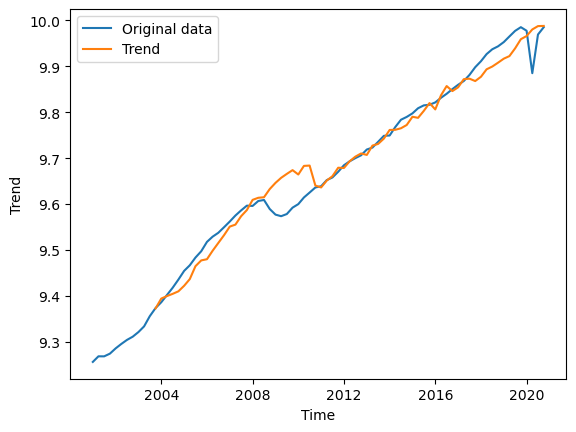

In [21]:
# Hamilton filter
ts = df3['GDP']  # GDP from this dataframe is already with log transformation
cycle, trend =  hamilton_filter(ts, h = 8, p = 4)
s = pd.Series(trend, index=df3['GDP'].index)
fig, ax = plt.subplots()
ax.plot(df3['GDP'], label='Original data')
ax.plot(s, label='Trend')
ax.legend(loc='upper left')
ax.set_xlabel("Time")
ax.set_ylabel("Trend")

In [22]:
cyc = pd.Series(cycle, index=df3['GDP'].index)

In [23]:
# the mean zero line which would be used for plotting below
mean = np.zeros(80)
final = pd.DataFrame(cyc)
final['zeros'] = mean
final = final.rename(columns={0: 'cycle'})
final_hp = final.copy()
final = final.iloc[11:,:]

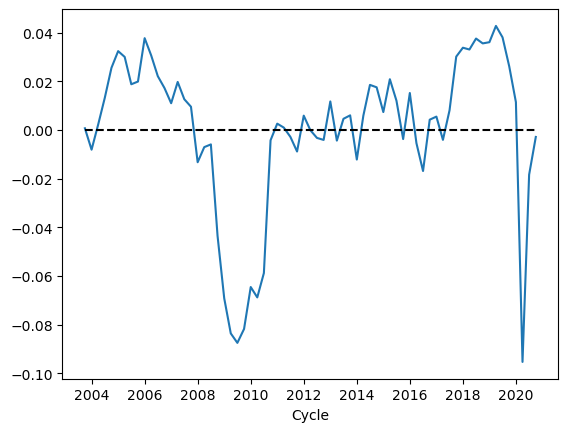

In [24]:
fig, ax = plt.subplots()
ax.plot(final['cycle'], label='Cycle')
ax.plot(final['zeros'], 'k--')
years = pd.date_range(start=df3.iloc[11:,:].index[0], end=df3.index[-1], freq='2AS')
ax.set_xticks(years)
year_labels = [year.strftime('%Y') for year in years]
ax.set_xticklabels(year_labels)
ax.set_xlabel('Cycle')
plt.show()

#### Comment: 
By using the Hamilton filter trend and cyclical components were extracted and we can observe that the cyclical component during the recession decline significant. Since cycle in the time series indicates the short-term changes in long-time time series, short-term changes often decrease during a recession when economic activity decreases.

#### How severely did Covid-19 affect the business cycle during the spring of 2020? 
The business cycle in the spring of 2020 suffered significantly from the Covid-19 pandemic. When the USA employed lockdowns and social isolation strategies, several economic sectors and overall output gap experienced a severe decline in activity.

### i)	As a robustness, to convince your boss that what you found above was not only due to the method you used, choose a different trend-cycle method, and re-do the analysis. 

For checking robustness of Hamilton filter we will use HP filter which is often used in economics. However, one of the disadvantages of this filter, is that it has a smoothing parameter $\lambda$ and how to correctly select this parameter is not explicitly stated in the literature.

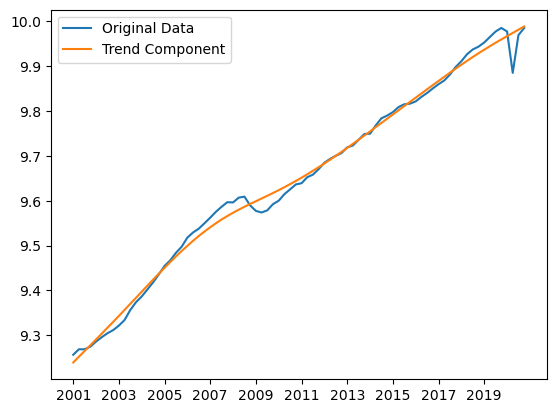

In [25]:
# apply the Hodrick-Prescott filter
cycle, trend = sm.tsa.filters.hpfilter(df3['GDP'])

# plot the original data and the trend component
fig, ax = plt.subplots()
ax.plot(df3.index, df3['GDP'], label='Original Data')
ax.plot(df3.index, trend, label='Trend Component')
ax.legend(loc='upper left')
years = pd.date_range(start=df3.index[0], end=df3.index[-1], freq='2AS')
ax.set_xticks(years)
year_labels = [year.strftime('%Y') for year in years]
ax.set_xticklabels(year_labels)
plt.show()

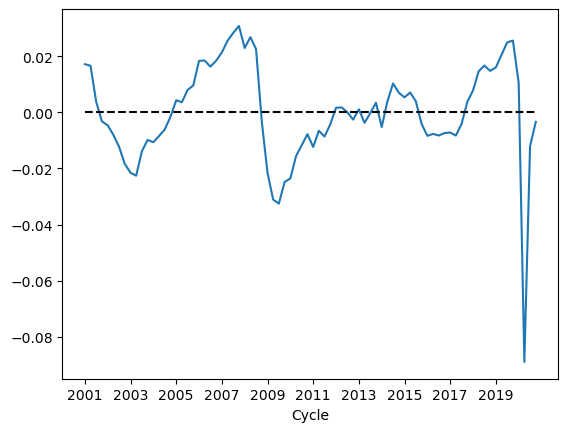

In [26]:
fig, ax = plt.subplots()
ax.plot(cycle, label='Cycle')
ax.plot(final_hp['zeros'], 'k--')
years = pd.date_range(start=df3.index[0], end=df3.index[-1], freq='2AS')
ax.set_xticks(years)
year_labels = [year.strftime('%Y') for year in years]
ax.set_xticklabels(year_labels)
ax.set_xlabel('Cycle')
plt.show()

Check for robustness by applying different lambda parameters

Text(0, 0.5, 'Cycle')

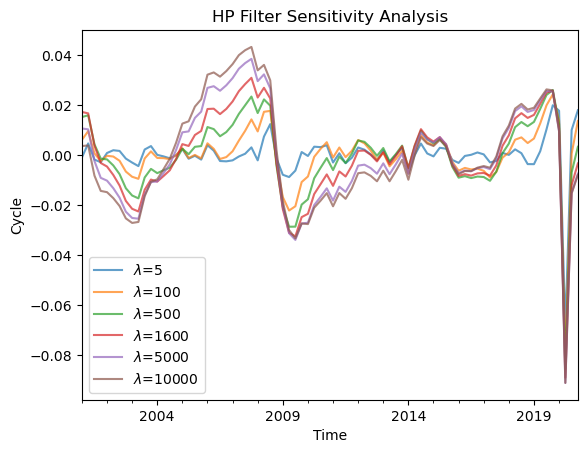

In [27]:
ts = df3['GDP']

# Apply the HP filter with different smoothing parameters
lambdas = [5, 100, 500, 1600, 5000, 10000]
results = pd.DataFrame()
for lam in lambdas:
    cycle, trend = hpfilter(ts, lamb=lam)
    results[f"$\lambda$={lam}"] = cycle

# Plot the results
ax = results.plot(title="HP Filter Sensitivity Analysis", alpha=0.7)
ax.set_xlabel("Time")
ax.set_ylabel("Cycle")

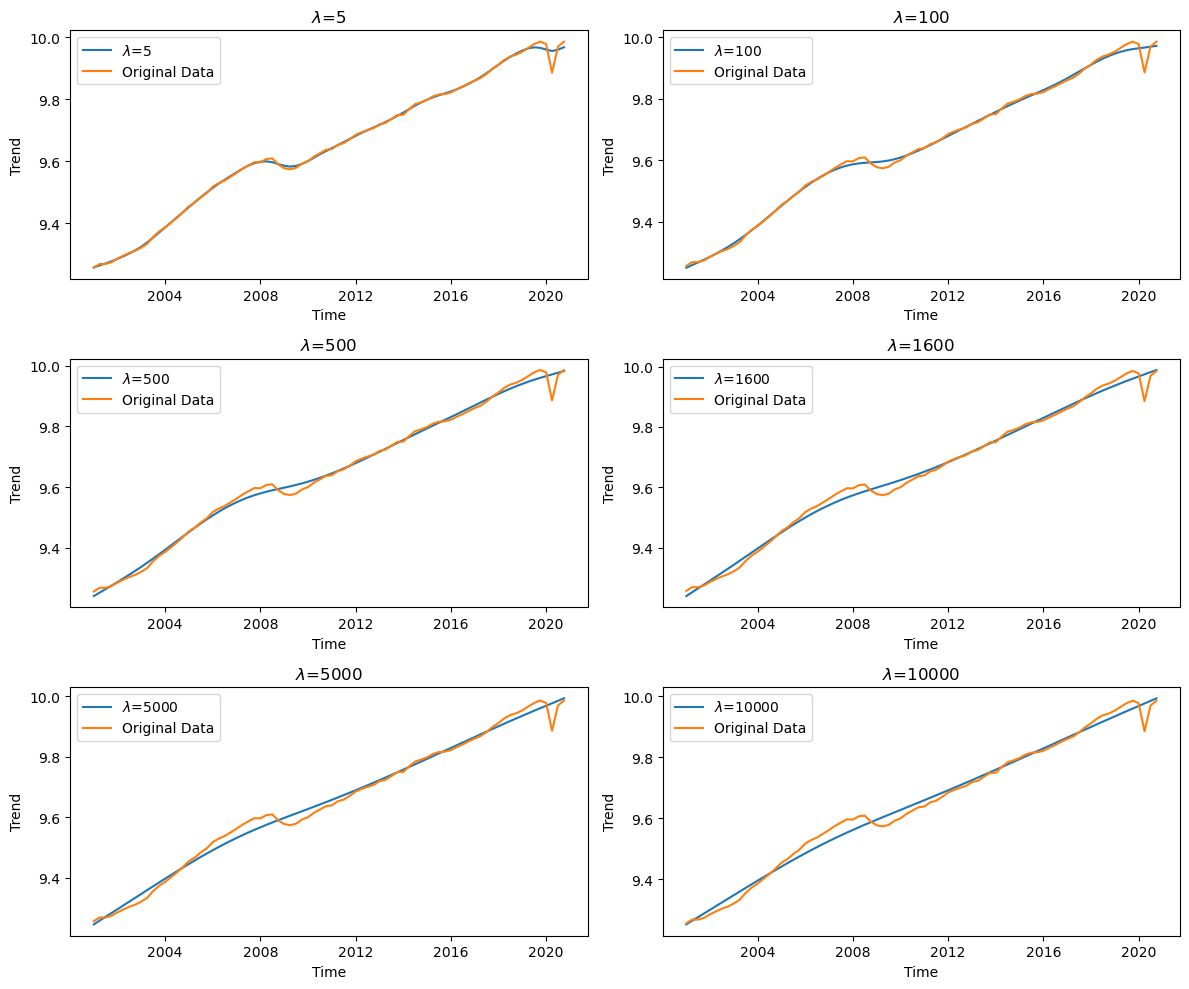

In [28]:
ts = df3['GDP']
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))

# Apply the HP filter with different smoothing parameters and plot the results
lambdas = [5, 100, 500, 1600, 5000, 10000]
for i, lam in enumerate(lambdas):
    row = i // 2  # Compute row index
    col = i % 2   # Compute column index
    cycle, trend = hpfilter(ts, lamb=lam)
    axs[row, col].plot(trend, label=f"$\lambda$={lam}")
    axs[row, col].plot(df3.index, df3['GDP'], label='Original Data')
    axs[row, col].set_title(f"$\lambda$={lam}")
    axs[row, col].set_xlabel("Time")
    axs[row, col].set_ylabel("Trend")
    axs[row, col].legend()

plt.tight_layout()
plt.show()

#### Comment on the plots:

From the plots above we can observe that by applying different smoothing parameters the emphasis of the algorithm changes from finding a smoother shape for the trend to accurately fitting the original time series. 

The algorithm estimates a straight line for the full series when  $\lambda$ is a maximum value (10000). As a result, important information and trends of the initial data may be lost. On the other hand, the algorithm only uses the initial time series to minimize the residuals when $\lambda$ = 0, completely rejecting the smoothing.

Also, the cyclical component in the Hamilton filter captures the recession period more accurately compared with HP filter, approximately  -0.09 and -0.03 respectively.


Thus, it's better to choose the Hamilton filter because we do not need to choose smoothing parameters and it is more suitable for tracking periods of economic crisis or other shocks. Compared to the HP filter, which is less resistant to volatility changes and may cause mistaken fluctuations in the cyclical component during high volatility, Hamilton filter t is more beneficial for capturing volatile periods.